## 평균 회귀 전략
* 낙폭이 심했던 주가는 다시 평균 수준으로 돌아온다는 가정
* 최근에 주가가 크게 하락한 종목을 매수

In [1]:
import os
import pandas as pd
from tqdm import tqdm

sp_data_dict = dict()
for file_name in os.listdir("data/주가데이터"):
    sp_data = pd.read_csv("data/주가데이터/" + file_name, parse_dates = ['Date'])
    stock_name = file_name.replace('.csv', '')
    sp_data_dict[stock_name] = sp_data

In [2]:
import seaborn as sns
from matplotlib import pyplot as plt
from matplotlib import rcParams

sns.set()
%matplotlib inline
rcParams['font.family'] = 'Malgun Gothic'
rcParams['axes.unicode_minus'] = False

In [3]:
# 주가 회복 비율 계산
# n1 영업일 이전에 m1 % 이상 떨어졌다가 n2 영업일 이내에 m2 % 이상 상승한 비율 계산

def count_loss_and_recover(sp_data, n1, n2, m1, m2):
    num_loss = 0
    num_recover = 0
    cur_price_list = sp_data["Close"].values
    n1_rmax_list = sp_data["Close"].rolling(n1).max().values
    n2_rmax_list = sp_data["Close"].rolling(n2).max().values
    pre_loss_list = (n1_rmax_list - cur_price_list) / n1_rmax_list * 100

    for i in range(n1, len(sp_data) - n2):
        if pre_loss_list[i] >= m1:
            num_loss += 1
            if n2_rmax_list[i+n2] >= cur_price_list[i] * (1+m2 / 100):
                num_recover += 1
    return num_recover, num_loss

In [4]:
import numpy as np

# 위에서 작성한 함수를 모든 종목에 적용한 결과를 합하는 함수
def sum_count_loss_and_recover(sp_data_dict, n1, n2, m1, m2):
    total_num_recover, total_num_loss = 0, 0
    for stock_name in sp_data_dict.keys():
        sp_data = sp_data_dict[stock_name]
        num_recover, num_loss = count_loss_and_recover(sp_data, n1, n2, m1, m2)

        total_num_recover += num_recover
        total_num_loss += num_loss
    if total_num_loss > 0:
        result = total_num_recover / total_num_loss
    else:
        result = np.nan

    return result

In [7]:
def make_heatmap(n1, n2, m1_range, m2_range):
    graph_data = []
    for m1 in tqdm(m1_range):
        record = []
        for m2 in m2_range:
            result = sum_count_loss_and_recover(sp_data_dict, n1, n2, m1, m2)
            record.append(result)
        graph_data.append(record)

    sns.heatmap(graph_data, annot = True, fmt = ".2f", linewidth = 1)
    plt.xticks(np.arange(0.5, len(m2_range), 1), m2_range)
    plt.yticks(np.arange(0.5, len(m1_range), 1), m1_range)
    plt.show()

100%|██████████| 6/6 [03:49<00:00, 38.30s/it]


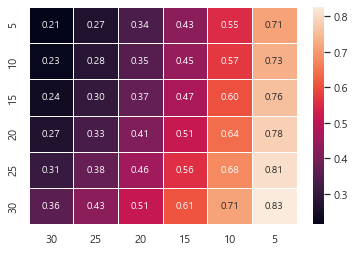

In [8]:
# 주가회복률 시각화

make_heatmap(60, 60, range(5, 31, 5), range(30, 0, -5))

# x축 : m2_range, y축 : m1_range
# ex) 우측 하단의 0.83 : 60 영업일 이전에 30% 이상 하락한 주가가 60 영업일 이내에 5% 이상 회복할 가능성이 83%이다.
# 당연하게도, 낙폭이 클수록 상승폭이 작을수록 확률이 높아짐

100%|██████████| 6/6 [04:13<00:00, 42.31s/it]


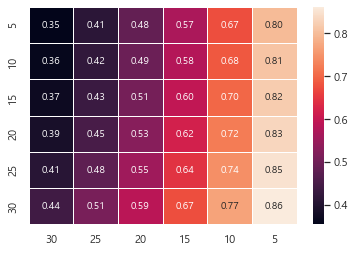

In [9]:
make_heatmap(120, 120, range(5, 31, 5), range(30, 0, -5))

100%|██████████| 6/6 [04:55<00:00, 49.20s/it]


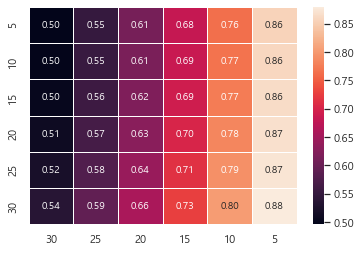

In [10]:
make_heatmap(240, 240, range(5, 31, 5), range(30, 0, -5))

# 기간이 길어질수록 회복률이 높아짐

## 평균 회귀 전략 검증
* n1 영업일 이전 동안 m1% 이상 하락한 종목 매수, n2 영업일 이내에 m2 % 이상 상승하면 매도하고 상승하지 못하면 n2 영업일 이후에 매도했을 때 수익률 계산

In [14]:
def calc_ror_using_mean_reg(sp_data_dict, n1, n2, m1, m2):
    ror_list = []

    for stock_name in tqdm(sp_data_dict.keys()):
        sp_data = sp_data_dict[stock_name]
        cur_price_list = sp_data["Close"].values
        n1_rmax_list = sp_data["Close"].rolling(n1).max().values
        pre_loss_list = (n1_rmax_list - cur_price_list) / n1_rmax_list * 100
        for i in range(n1, len(sp_data) - n2 + 1):
            if pre_loss_list[i] >= m1:
                bp = cur_price_list[i] # 매수가
                cand_sp_list = sp_data.loc[i:i+n2, "Close"].values # 매도가 후보
                if cand_sp_list.max() > bp * (1+m2/100): # 원하는 수준에 도달하면
                    sp = cand_sp_list[cand_sp_list > bp * (1+m2/100)][0]
                else:
                    sp = cand_sp_list[-1]

                ror = (sp - bp) / bp * 100
                ror_list.append(ror)

    return ror_list

In [15]:
n1 = 20
n2 = 20
m1 = 5
m2 = 5
ror_list = calc_ror_using_mean_reg(sp_data_dict, n1, n2, m1, m2)

print(pd.Series(ror_list).describe().round(3))

# 평균이 0에 가깝지만 중위값이 5.172로, 절반 이상은 20 영업일 이내에 5% 이상의 수익을 거둠

100%|██████████| 2170/2170 [02:58<00:00, 12.17it/s]


count    2455248.000
mean           0.749
std           10.989
min          -89.120
25%           -5.285
50%            5.173
75%            6.855
max          900.114
dtype: float64


In [16]:
n1 = 60
n2 = 120
m1 = 20
m2 = 10
profit_list = calc_ror_using_mean_reg(sp_data_dict, n1, n2, m1, m2)

print(pd.Series(profit_list).describe().round(3))

100%|██████████| 2170/2170 [01:10<00:00, 30.74it/s]


count    1060891.000
mean           5.447
std           17.838
min          -96.688
25%           10.010
50%           11.304
75%           13.983
max          900.000
dtype: float64


In [17]:
n1 = 240
n2 = 240
m1 = 30
m2 = 30
profit_list = calc_ror_using_mean_reg(sp_data_dict, n1, n2, m1, m2)

print(pd.Series(profit_list).describe().round(3))

# 기간이 길어질수록 수익률이 높아짐

100%|██████████| 2170/2170 [01:28<00:00, 24.60it/s]


count    1426574.000
mean          10.181
std           32.508
min          -96.419
25%          -16.172
50%           30.319
75%           33.803
max          945.303
dtype: float64


## 종목 유형에 따른 검증
* 코스피, 코스닥, 시가총액 기준 상위 100개 종목에 대해 적용

In [18]:
stock_info = pd.read_csv("data/종목정보.txt", sep = "\t", encoding = "euc-kr")
market_cap = pd.read_excel("data/211104_시가총액.xlsx")

In [19]:
# 코스피, 코스닥, 시총 상위 구분

stock_info = pd.read_excel("data/211104_시가총액.xlsx")
KOSPI_list = stock_info.loc[stock_info["시장구분"] == "KOSPI", "종목명"].values
KOSDAQ_list = stock_info.loc[stock_info["시장구분"] == "KOSDAQ", "종목명"].values
TOP100_list = stock_info.sort_values(by = "시가총액", ascending = False)["종목명"].values[:100]

In [20]:
KOSPI_sp_data_dict = dict()
KOSDAQ_sp_data_dict = dict()
TOP100_sp_data_dict = dict()

for stock_name in sp_data_dict.keys():
    if stock_name in KOSPI_list:
        KOSPI_sp_data_dict[stock_name] = sp_data_dict[stock_name]
    if stock_name in KOSDAQ_list:
        KOSDAQ_sp_data_dict[stock_name] = sp_data_dict[stock_name]
    if stock_name in TOP100_list:
        TOP100_sp_data_dict[stock_name] = sp_data_dict[stock_name]

## 코스피 종목

In [21]:
n1 = 20
n2 = 20
m1 = 5
m2 = 5

ror_list = calc_ror_using_mean_reg(KOSPI_sp_data_dict, n1, n2, m1, m2)

print(pd.Series(ror_list).describe().round(3))

100%|██████████| 779/779 [01:00<00:00, 12.92it/s]


count    895400.000
mean          0.563
std          11.278
min         -77.156
25%          -5.022
50%           5.020
75%           6.467
max         900.114
dtype: float64


In [22]:
n1 = 60
n2 = 120
m1 = 20
m2 = 10
ror_list = calc_ror_using_mean_reg(KOSPI_sp_data_dict, n1, n2, m1, m2)

print(pd.Series(ror_list).describe().round(3))

100%|██████████| 779/779 [00:21<00:00, 36.37it/s]


count    333122.000
mean          5.087
std          17.890
min         -89.824
25%           1.316
50%          11.097
75%          13.433
max         900.000
dtype: float64


In [23]:
n1 = 240
n2 = 240
m1 = 30
m2 = 30
ror_list = calc_ror_using_mean_reg(KOSPI_sp_data_dict, n1, n2, m1, m2)

print(pd.Series(ror_list).describe().round(3))

# 전 종목에 적용했을때보다 평균이 낮고 편차가 큼
# 코스피 종목보다는 임의의 종목에 적용하는게 더 나음

100%|██████████| 779/779 [00:28<00:00, 26.94it/s]

count    487604.000
mean          8.582
std          33.204
min         -95.737
25%         -16.667
50%          18.148
75%          32.954
max         945.303
dtype: float64


## 코스닥 종목

In [24]:
n1 = 20
n2 = 20
m1 = 5
m2 = 5
ror_list = calc_ror_using_mean_reg(KOSDAQ_sp_data_dict, n1, n2, m1, m2)

print(pd.Series(ror_list).describe().round(3))

100%|██████████| 1355/1355 [01:32<00:00, 14.63it/s]


count    1521324.000
mean           0.853
std           10.776
min          -89.120
25%           -5.455
50%            5.263
75%            7.077
max          137.304
dtype: float64


In [25]:
n1 = 60
n2 = 120
m1 = 20
m2 = 10
ror_list = calc_ror_using_mean_reg(KOSDAQ_sp_data_dict, n1, n2, m1, m2)

print(pd.Series(ror_list).describe().round(3))

100%|██████████| 1355/1355 [00:44<00:00, 30.56it/s]


count    705201.000
mean          5.651
std          17.676
min         -96.688
25%          10.048
50%          11.407
75%          14.206
max         200.266
dtype: float64


In [26]:
n1 = 240
n2 = 240
m1 = 30
m2 = 30
ror_list = calc_ror_using_mean_reg(KOSDAQ_sp_data_dict, n1, n2, m1, m2)

print(pd.Series(ror_list).describe().round(3))

# 코스피 종목에 적용했을때보다 수익률이 높음
# !! 상장 폐지 종목은 데이터에서 없기 때문에 맹신하면 안됨 !! - bias

100%|██████████| 1355/1355 [01:05<00:00, 20.81it/s]


count    911954.000
mean         11.055
std          31.928
min         -96.419
25%         -15.727
50%          30.545
75%          34.211
max         207.030
dtype: float64


## 시총 상위 100개 우량 종목

In [27]:
n1 = 20
n2 = 20
m1 = 5
m2 = 5
ror_list = calc_ror_using_mean_reg(TOP100_sp_data_dict, n1, n2, m1, m2)

print(pd.Series(ror_list).describe().round(3))

100%|██████████| 86/86 [00:06<00:00, 13.67it/s]

count    90412.000
mean         0.722
std          8.363
min        -58.795
25%         -4.236
50%          5.049
75%          6.227
max        106.721
dtype: float64


In [28]:
n1 = 60
n2 = 120
m1 = 20
m2 = 10
ror_list = calc_ror_using_mean_reg(TOP100_sp_data_dict, n1, n2, m1, m2)

print(pd.Series(ror_list).describe().round(3))

100%|██████████| 86/86 [00:01<00:00, 49.95it/s]

count    23669.000
mean         5.991
std         13.596
min        -76.103
25%         10.063
50%         10.938
75%         12.529
max         42.156
dtype: float64


In [29]:
n1 = 240
n2 = 240
m1 = 30
m2 = 30
ror_list = calc_ror_using_mean_reg(TOP100_sp_data_dict, n1, n2, m1, m2)

print(pd.Series(ror_list).describe().round(3))

# 우량 종목 또한 코스피보다 수익률이 큼
# 코스닥에 비해선 낮은 수익률이지만, 상장 폐지 위험이 낮기 때문에 전략을 적용하기 더 적당함

100%|██████████| 86/86 [00:02<00:00, 36.93it/s]

count    34748.000
mean        10.488
std         28.264
min        -88.706
25%        -11.789
50%         28.778
75%         31.845
max        123.353
dtype: float64
